In [6]:
import numpy as np
import scipy.stats as stats
import seaborn as sns

# Engine

## Exponential function

In [7]:
def pexp(lambda_, x):
    """ PDF for exponential distribution

    Args:
        lambda_ (int): the rate
        x (int): the random variable. Intuitively, for example the time that has passed 
        since the previous event

    Returns:
        float: the probability density at that x. Intuitively,
        for example the probability of having an event at time x
    """
    return lambda_* np.exp(-lambda_ * x)

def dexp(lambda_, x):
    """ CDF for exponential distribution

    Args:
        lambda_ (int): the rate
        x (int): the random variable. Intuitively, for example the time that has passed 
        since the previous event

    Returns:
        float: the cumulative probability of all values between 0 and x,
        inclusive. 
        Intuitively, for example the probability of having an event 
        at any time before and including x
    """
    return -1 * np.exp(-lambda_ * x)

def qexp(lambda_, p):
    """Quantile function for the exponential distribution
    The result of the quantile is the exponential distributed random variable that has 
    probability `p` or less.
    It can be interpreted as the 'cumulative function' for the probabilities and 
    therefore, the inverse of the cumulative distribution of a exponentially 
    distributed random value.

    Args:
        lambda_ (int): the rate
        p (float): the probability to evaluate the quantile
        
    Returns:
        float: the quantile, or inverse cumulative distribution, at p
    """
    return (-1/lambda_) * np.log(1-p)


def rexp(lambda_):
    """ Draws a value from the exponential distribution.
    Drawing will be done through the Inverse Transform sampling Method.
    So we want to find a number x for which FX(x) = U; where X is a 
    random variable (exponential variable in this case) and U is a 
    uniform random variable and FX its distribution function 
    (exponential distribution in this case). So this means that to find x
    (the goal of this whole function) we need to solve for x = F^(-1)_x(U).
    
    So the steps are:
    - calculate the inverse of the exponential CDF: F^(-1)_x
    - draw a uniform random probability U (from the interval [0,1], of course)
    - calculate x = F^(-1)_x(U)

    Args:
        lambda_ (int): the rate

    Returns:
        float: a random exponential variable
    """
    u = np.random.uniform(low=0, high=1, size=1)
    t = qexp(lambda_=lambda_, p=u)
    return t.item()

## Test exponential random variable generation

d:\anaconda3\envs\stats\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


KstestResult(statistic=0.2737194448369725, pvalue=1.0693401989623529e-66, statistic_location=1.4555134503506002, statistic_sign=-1)

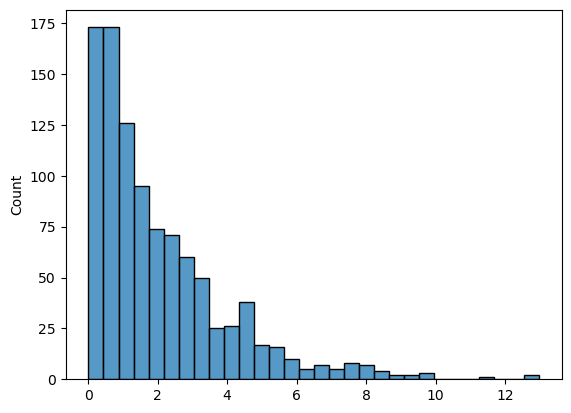

In [8]:
to_test = [rexp(0.5) for i in range(1000)]
sns.histplot(to_test)
stats.kstest(to_test, "expon")

d:\anaconda3\envs\stats\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\anaconda3\envs\stats\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


KstestResult(statistic=0.03, pvalue=0.7593695685682871, statistic_location=2.370920522896573, statistic_sign=-1)

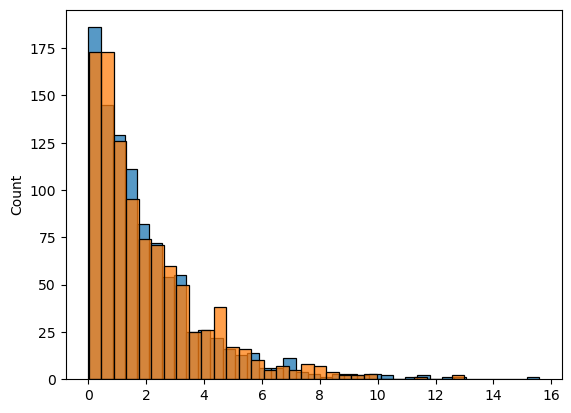

In [9]:
r = stats.expon.rvs(size=1000, scale=1/0.5)
sns.histplot(r)
sns.histplot(to_test)
stats.kstest(to_test, r)

## Simulation engine

In [ ]:
def gillespie_simulation(L, T, LT, k_bind, k_dissociate, t_vec, cycles, steps):
    for i in range(cycles):
        for j in range(steps):
            # Calculate partial reaction rates
            r_bind = k_bind * L[i, j] * T[i, j]
            r_dissociate = k_dissociate * LT[i, j]

            # Calculate global reaction rate
            r_total = r_bind + r_dissociate

            # Calculate probabilities of each reaction
            p_LT = r_bind / r_total
            # p_L_T = r_dissociate / r_total  # only one of these 2 are needed

            # Calculate time to next reaction
            time_next_reaction = rexp(lambda_=r_total)
            t_vec[i, j+1] = t_vec[i, j] + time_next_reaction
            
            # Select which reaction occured
            u = np.random.uniform(low=0, high=1, size=1)

            if u < p_LT:
                L[i, j+1] = L[i, j] - 1
                T[i, j+1] = T[i, j] - 1
                LT[i, j+1] = LT[i, j] + 1
            else:
                L[i, j+1] = L[i, j] + 1
                T[i, j+1] = T[i, j] + 1
                LT[i, j+1] = LT[i, j] - 1
                
    return L, T, LT, t_vec


# Simulate with physiological constants

In [10]:
# Fix model parameters
k_bind = 0.0146
k_dissociate = 35

L0 = 10000
T0 = 7000
LT0 = 0

steps = 25    # Number of reactions per trajectory
cycles = 1  # Number of trajectories iterated over

# Set up holder arrays
t = np.zeros((cycles, steps+1))
L = np.zeros((cycles, steps+1))
T = np.zeros((cycles, steps+1))
LT = np.zeros((cycles, steps+1))

# Store initial conditions
L[:, 0] = L0
T[:, 0] = T0
LT[:, 0] = LT0
